# Classify concentrations from rivers in ANHA12

Classified based on:
- glaciers
- continental drainage
- near (old) mines

File containing this classification: river_class_201807.nc

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from salishsea_tools import nc_tools, viz_tools
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import csv

In [6]:
c = nc.Dataset('/ocean/brogalla/GEOTRACES/data/runoff/runoff_core_monthly.nc','r')
nc_tools.show_dimensions(c)
nc_tools.show_variables(c)

# Load structure from sample dataset:
lon_rf = c.variables['nav_lon']
lat_rf = c.variables['nav_lat']
socoefr = c.variables['socoefr']
rf = c.variables['runoff'][0]

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1632

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 12

odict_keys(['nav_lon', 'nav_lat', 'time_counter', 'socoefr', 'runoff'])


In [7]:
rf = np.array(rf)
lon_rf = np.array(lon_rf)
lat_rf = np.array(lat_rf)
rf[rf == 0] = np.nan
#lon_rf[rf == 0.0] = np.nan
#lat_rf[rf == 0.0] = np.nan

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0,0.5,'Latitude')

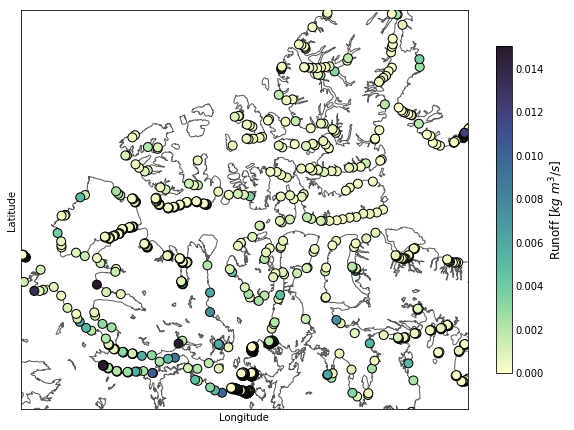

In [8]:
# Plot the runoff:
fig,ax = plt.subplots(figsize=(10,10))# Gallium:
proj=Basemap(projection='eqdc', lat_0=74, lon_0=-95, resolution='i', 
             llcrnrlon=-120, llcrnrlat=65, urcrnrlon=-50, urcrnrlat=80)
proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1);
x_rf, y_rf = proj(lon_rf, lat_rf)

CS = proj.scatter(x_rf, y_rf, c=rf,vmin=0,vmax=0.015, s=80, cmap=cmocean.cm.deep, zorder=3, edgecolors='k')
CBar = plt.colorbar(CS, shrink=0.6)
CBar.set_label('Runoff [$kg\ m^3 / s$]', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# River categories:

1. Glaciers
2. Continental
3. Other

In [10]:
rclass = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/rivers/river_class_201807.nc','r')
nc_tools.show_dimensions(rclass)
nc_tools.show_variables(rclass)

# Load structure from sample dataset:
river_class = rclass.variables['rclass']

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1632

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400

odict_keys(['rclass'])


In [30]:
river_class = np.array(river_class)

# From classes, correct trace metal concentrations

Notebook to find these concentratons: /analysis-birgit/notebooks/scavenging/river-region-concentrations

In [31]:
print(river_class.shape)

(2400, 1632)


In [32]:
pMn_rivers = np.zeros(river_class.shape)
dMn_rivers = np.zeros(river_class.shape)
pPb_rivers = np.zeros(river_class.shape)
dPb_rivers = np.zeros(river_class.shape)

Manganese:

In [33]:
pMn_rivers[river_class==1.0] = 151 # glaciers
pMn_rivers[river_class==2.0] = 13  # continental
pMn_rivers[river_class==3.0] = 2   # other

In [34]:
dMn_rivers[river_class==1.0] = 164 # glaciers
dMn_rivers[river_class==2.0] = 30  # continental
dMn_rivers[river_class==3.0] = 2   # other

Lead:

In [35]:
pPb_rivers[river_class==1.0] = 5 # glaciers
pPb_rivers[river_class==2.0] = 1  # continental
pPb_rivers[river_class==3.0] = 0.2   # other

In [36]:
dPb_rivers[river_class==1.0] = 35 # glaciers
dPb_rivers[river_class==2.0] = 43  # continental
dPb_rivers[river_class==3.0] = 2   # other

#### Convert units to mol/L:

In [37]:
dMn_rivers = dMn_rivers*10**(-9)      # nM --> 10^-3 mol/L
pMn_rivers = pMn_rivers*(1/54.938049)*10**(-6) # micro g/L --> 1.82*10^-2 mol/L

In [38]:
print(np.amax(dMn_rivers))
print(np.amax(pMn_rivers))

1.64e-07
2.74855046272e-06


In [39]:
dPb_rivers = dPb_rivers*10**(-12)           # pM --> 10^-3 mol/L
pPb_rivers = pPb_rivers*(1/207.2)*10**(-6) # micro g/L --> 1.82*10^-2 mol/L

In [40]:
print(np.amax(dPb_rivers))
print(np.amax(pPb_rivers))

4.3e-11
2.41312741313e-08


# Write to NetCDF file

In [41]:
c = nc.Dataset('/ocean/brogalla/GEOTRACES/data/runoff/runoff_core_monthly.nc','r')

In [42]:
# Load structure from sample dataset:
lon = c.variables['nav_lon']
lat = c.variables['nav_lat']
socoefr = c.variables['socoefr']
rf = c.variables['runoff']
BX = c.dimensions['x']
BY = c.dimensions['y']

In [47]:
# Setup the new NetCDF file:
ncd = nc.Dataset('river_input.nc', 'w', zlib=True)
nc_tools.init_dataset_attrs(
    ncd,
    title='Tracer input from rivers',
    notebook_name='rivers',
    nc_filepath='./river_input.nc',
    comment='Input of tracer concentration from rivers')

ncd.createDimension('x',len(BX))
ncd.createDimension('y',len(BY))

file format: NETCDF4
Conventions: CF-1.6
title: Tracer input from rivers
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/rivers/Classification/rivers.ipynb
references: REQUIRED
history: [2018-07-25 11:08:12] Created netCDF4 zlib=True dataset.
comment: Input of tracer concentration from rivers


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400

In [48]:
# variables
nav_lat = ncd.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat[:] = lat_rf

nav_lon = ncd.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon[:] = lon_rf

pmn_rivers = ncd.createVariable('pmn_rivers', 'float32', ('y','x'))
pmn_rivers.units = 'mol/L'
pmn_rivers.long_name = 'Oxidised Mn concentration'  
pmn_rivers.coordinates = 'nav_lon nav_lat'
pmn_rivers[:] = pMn_rivers

dmn_rivers = ncd.createVariable('dmn_rivers', 'float32', ('y','x'))
dmn_rivers.units = 'mol/L'
dmn_rivers.long_name = 'Dissolved Mn concentration'  
dmn_rivers.coordinates = 'nav_lon nav_lat'
dmn_rivers[:] = dMn_rivers

ppb_rivers = ncd.createVariable('ppb_rivers', 'float32', ('y','x'))
ppb_rivers.units = 'mol/L'
ppb_rivers.long_name = 'Particulate Pb concentration'  
ppb_rivers.coordinates = 'nav_lon nav_lat'
ppb_rivers[:] = pPb_rivers

dpb_rivers = ncd.createVariable('dpb_rivers', 'float32', ('y','x'))
dpb_rivers.units = 'mol/L'
dpb_rivers.long_name = 'Dissolved Pb concentration'  
dpb_rivers.coordinates = 'nav_lon nav_lat'
dpb_rivers[:] = dPb_rivers

In [49]:
nc_tools.check_dataset_attrs(ncd)
ncd.close()

Missing value for dataset attribute: references


In [50]:
c = nc.Dataset('./river_input.nc','r')
print(np.amax(c.variables['dmn_rivers']))
print(np.amax(c.variables['pmn_rivers']))
print(np.amax(c.variables['dpb_rivers']))
print(np.amax(c.variables['ppb_rivers']))

1.64e-07
2.74855e-06
4.3e-11
2.41313e-08
